In [21]:
# =============================================================================
# CELL 1: SYSTEM CONFIG (PRODUCTION READY)
# =============================================================================

import os
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error

# Tắt cảnh báo
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Cấu hình Path
MODEL_DIR = "quant_models"  # Thư mục chứa model đã train
DATA_FILE = "vn30_historical_data.csv"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

def direction_accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Tính hướng (tăng/giảm) và so sánh
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

class Config:
    # VN30 Full List
    VN30_MAPPING = {
        "ACB": "ACB", "BCM": "BCM", "BID": "BID", "CTG": "CTG", "DGC": "DGC",
        "FPT": "FPT", "GAS": "GAS", "GVR": "GVR", "HDB": "HDB", "HPG": "HPG",
        "LPB": "LPB", "MBB": "MBB", "MSN": "MSN", "MWG": "MWG", "PLX": "PLX",
        "SAB": "SAB", "SHB": "SHB", "SSB": "SSB", "SSI": "SSI", "STB": "STB",
        "TCB": "TCB", "TPB": "TPB", "VCB": "VCB", "VHM": "VHM", "VIB": "VIB",
        "VIC": "VIC", "VJC": "VJC", "VNM": "VNM", "VPB": "VPB", "VRE": "VRE"
    }
    TICKERS = list(VN30_MAPPING.keys())
    
    START_DATE = "2020-01-01" # Dữ liệu dài để học nhiều mẫu hình
    END_DATE = datetime.now().strftime('%Y-%m-%d')
    
    PREDICTION_HORIZON = 3    # Dự báo T+3
    MIN_DATA_POINTS = 100     # Yêu cầu tối thiểu

print("✅ System Configured. Model Directory Ready.")

✅ System Configured. Model Directory Ready.


In [22]:
# =============================================================================
# CELL 2: DATA ENGINE (CACHED)
# =============================================================================
import time
try:
    from vnstock import Vnstock
except:
    print("❌ Chưa cài vnstock.")

class DataEngine:
    @staticmethod
    def fetch_data_safe(symbol):
        try:
            # Thử VCI trước
            stock = Vnstock().stock(symbol=symbol, source='VCI')
            df = stock.quote.history(start=Config.START_DATE, end=Config.END_DATE, interval='1D')
            if df is None or df.empty: return None
            
            df.columns = [str(c).lower() for c in df.columns]
            rename_map = {'time':'date','tradingdate':'date','vol':'volume','high':'high','low':'low','open':'open','close':'close'}
            df = df.rename(columns=rename_map)
            
            if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])
            cols = ['open', 'high', 'low', 'close', 'volume']
            for c in cols: 
                if c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce')
            
            df = df.sort_values('date').reset_index(drop=True)
            df['ticker'] = symbol
            return df
        except: return None

    @staticmethod
    def get_data(tickers):
        if os.path.exists(DATA_FILE):
            print(f"📂 Load dữ liệu từ cache '{DATA_FILE}'...", end=" ")
            df = pd.read_csv(DATA_FILE)
            df['date'] = pd.to_datetime(df['date'])
            print(f"✅ OK ({len(df)} records)")
            return df

        print("🌐 Tải dữ liệu mới (Chậm để an toàn)...")
        dfs = []
        for i, t in enumerate(tickers):
            print(f"   [{i+1}/{len(tickers)}] {t}...", end=" ")
            d = DataEngine.fetch_data_safe(t)
            if d is not None: 
                dfs.append(d)
                print("✅", end=" ")
            else: print("❌", end=" ")
            
            if i < len(tickers)-1: 
                time.sleep(15) 
                print("| Wait 15s...", end="\r")
        
        full_df = pd.concat(dfs, ignore_index=True)
        full_df.to_csv(DATA_FILE, index=False)
        print(f"\n💾 Saved to {DATA_FILE}")
        return full_df

In [23]:
# =============================================================================
# CELL 3: FAST TECHNICAL ANALYSIS
# =============================================================================

class TechnicalAnalysis:
    @staticmethod
    def rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
        rs = gain / (loss.replace(0, 1e-9))
        return 100 - (100 / (1 + rs))

    @staticmethod
    def macd(series, f=12, s=26, sig=9):
        k = series.ewm(span=f, adjust=False).mean()
        d = series.ewm(span=s, adjust=False).mean()
        macd = k - d
        signal = macd.ewm(span=sig, adjust=False).mean()
        return macd, signal

    @staticmethod
    def bollinger(series, n=20, k=2):
        sma = series.rolling(n).mean()
        std = series.rolling(n).std()
        return sma + k*std, sma, sma - k*std

    @staticmethod
    def mfi(high, low, close, vol, n=14):
        tp = (high + low + close) / 3
        mf = tp * vol
        pos = (mf.where(tp > tp.shift(), 0)).rolling(n).sum()
        neg = (mf.where(tp < tp.shift(), 0)).rolling(n).sum()
        return 100 - (100 / (1 + pos/(neg.replace(0, 1e-9))))

In [24]:
# =============================================================================
# CELL 4: SOTA FEATURES V2 (INTERACTIONS & REGIME)
# =============================================================================

class FeatureEngineer:
    @staticmethod
    def create_base_features(df):
        df = df.copy().sort_values(['ticker', 'date'])
        
        # 1. Base Indicators
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Vol_10'] = df['Log_Ret'].rolling(10).std()
        
        # RSI & MACD
        df['RSI'] = TechnicalAnalysis.rsi(df['close'], 14)
        macd, sig = TechnicalAnalysis.macd(df['close'])
        df['MACD_Div'] = (macd - sig) # Divergence
        
        # Bollinger %B
        u, m, l = TechnicalAnalysis.bollinger(df['close'])
        df['BB_Pb'] = (df['close'] - l) / (u - l + 1e-9)
        df['BB_Width'] = (u - l) / m
        
        # Volume features
        df['Vol_Ratio'] = df['volume'] / (df['volume'].rolling(20).mean() + 1)
        df['MFI'] = TechnicalAnalysis.mfi(df['high'], df['low'], df['close'], df['volume'])
        
        # 2. MARKET REGIME (Trạng thái thị trường)
        # Giá nằm trên hay dưới MA50? (1=Uptrend, 0=Downtrend)
        df['Trend_Regime'] = (df['close'] > df['close'].rolling(50).mean()).astype(int)
        
        # 3. INTERACTION FEATURES (Sự kết hợp quan trọng)
        # RSI cao nhưng MFI thấp? (Dòng tiền yếu)
        df['RSI_MFI_Div'] = df['RSI'] - df['MFI']
        # Biến động nhân với Volume (Sự hoảng loạn hoặc Hưng phấn)
        df['Panic_Score'] = df['Vol_10'] * df['Vol_Ratio']
        
        # 4. Lag Returns
        for lag in [1, 3, 5, 10]:
            df[f'Ret_{lag}d'] = df['close'].pct_change(lag)
            
        # 5. Raw Target (T+3)
        future_close = df.groupby('ticker')['close'].shift(-Config.PREDICTION_HORIZON)
        df['Raw_Target'] = (future_close - df['close']) / df['close']
        
        return df.dropna()

    @staticmethod
    def to_zscore(series):
        # Robust Z-Score (dùng Median để tránh nhiễu ngoại lai)
        median = series.median()
        iqr = series.quantile(0.75) - series.quantile(0.25)
        return (series - median) / (iqr + 1e-9)

    @staticmethod
    def process_data(raw_df):
        print("⚙️ Computing Advanced Interactions...", end=" ")
        processed = []
        for t in raw_df['ticker'].unique():
            sub = raw_df[raw_df['ticker'] == t]
            if len(sub) > 60:
                processed.append(FeatureEngineer.create_base_features(sub))
        
        if not processed: return pd.DataFrame()
        df = pd.concat(processed, ignore_index=True)
        
        # --- CROSS-SECTIONAL NORMALIZATION ---
        print("\n⚖️ Applying Robust Z-Scoring & Binning...")
        
        # Danh sách feature cần chuẩn hóa
        cols_to_norm = [
            'RSI', 'MACD_Div', 'BB_Pb', 'BB_Width', 'Vol_Ratio', 'MFI',
            'RSI_MFI_Div', 'Panic_Score', 
            'Ret_1d', 'Ret_3d', 'Ret_5d', 'Ret_10d'
        ]
        
        for col in cols_to_norm:
            # Z-Score theo ngày
            df[f'Z_{col}'] = df.groupby('date')[col].transform(FeatureEngineer.to_zscore)
            # Clip outlier (-3 đến 3)
            df[f'Z_{col}'] = df[f'Z_{col}'].clip(-3, 3)
        
        # Thêm feature Regime (không cần Z-score vì nó là binary 0/1)
        df['Z_Trend_Regime'] = df['Trend_Regime']
        
        # TARGET DISCRETIZATION (0-4)
        def discretize(x):
            try:
                # Chia thành 5 giỏ, mỗi giỏ 20%
                return pd.qcut(x, 5, labels=False, duplicates='drop')
            except:
                return np.zeros(len(x))

        df['Target_Rank'] = df.groupby('date')['Raw_Target'].transform(discretize)
        df['Target_Rank'] = df['Target_Rank'].fillna(2).astype(int) # 2 là Neutral
        
        print(f"✅ SOTA Data Ready. Shape: {df.shape}")
        return df.dropna()

In [25]:
# =============================================================================
# CELL 5: QUANT RANKER (DART BOOSTER - SOTA ARCHITECTURE)
# =============================================================================

class QuantRanker:
    def __init__(self):
        self.model_path = os.path.join(MODEL_DIR, "vn30_ranker_dart.json")
        
        # DART BOOSTER CONFIGURATION
        self.model = xgb.XGBRanker(
            booster='dart',          # <--- CHÌA KHÓA: Dùng DART thay vì gbtree
            objective='rank:ndcg',   # <--- CHÌA KHÓA: Tối ưu hóa Top list (NDCG)
            
            n_estimators=2000,        # Số lượng cây
            learning_rate=0.01,      # Học vừa phải
            
            # DART Parameters
            rate_drop=0.1,           # Drop 10% cây mỗi vòng (Giúp model không quá tự tin)
            skip_drop=0.5,           # 50% cơ hội bỏ qua drop
            
            # Tree Parameters
            max_depth=4,
            subsample=0.6,
            colsample_bytree=0.5,
            reg_lambda=50,           # L2 Regularization rất mạnh (chống nhiễu)
            reg_alpha=10,             # L1 Regularization (chọn lọc feature)
            
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        )
        self.features = []

    def train(self, df):
        df = df.sort_values('date').reset_index(drop=True)
        
        # Chỉ lấy Z-Features
        self.features = [c for c in df.columns if c.startswith('Z_')]
        
        # Split Train/Val (Walk-forward blocking)
        # Train 85%, Val 15% (Lấy giai đoạn khó khăn nhất làm Val)
        split_idx = int(len(df) * 0.85)
        train_df = df.iloc[:split_idx]
        val_df = df.iloc[split_idx:]
        
        X_train = train_df[self.features]
        y_train = train_df['Target_Rank'].astype(int)
        qid_train = train_df.groupby('date').ngroup().values
        
        X_val = val_df[self.features]
        y_val = val_df['Target_Rank'].astype(int)
        qid_val = val_df.groupby('date').ngroup().values
        
        print(f"\n🧠 Training Ultimate Ranker (DART) on {len(self.features)} Features...")
        print("   (DART train sẽ chậm hơn gbtree một chút nhưng bền vững hơn)")
        
        self.model.fit(
            X_train, y_train, qid=qid_train,
            eval_set=[(X_val, y_val)],
            eval_qid=[qid_val],
            verbose=100
        )
        
        self.model.save_model(self.model_path)
        joblib.dump(self.features, os.path.join(MODEL_DIR, "rank_features_dart.pkl"))
        print(f"💾 Model saved to: {self.model_path}")
        
        imp = pd.Series(self.model.feature_importances_, index=self.features).sort_values(ascending=False)
        print("\n🏆 Top 5 Key Factors:")
        print(imp.head(5))

    def load(self):
        if not os.path.exists(self.model_path): return False
        self.model.load_model(self.model_path)
        self.features = joblib.load(os.path.join(MODEL_DIR, "rank_features_dart.pkl"))
        return True

    def predict(self, df_latest):
        if not self.features: self.load()
        X = df_latest[self.features]
        return self.model.predict(X)

In [26]:
# =============================================================================
# CELL 6: REALTIME RANKING (SOTA V2 - DART COMPATIBLE)
# =============================================================================

def run_realtime_ranking():
    # 1. Setup & Load Data
    raw_df = DataEngine.get_data(Config.TICKERS)
    brain = QuantRanker()
    
    # Load model (Nếu chưa có thì train)
    if not brain.load():
        print("⚠️ Model chưa có, đang train lại...")
        df_full = FeatureEngineer.process_data(raw_df)
        brain.train(df_full)
    else:
        print("✅ SOTA DART Ranker Loaded.")

    print("\n🔮 ĐANG CHẠY REALTIME RANKING (DART BOOSTER)...")
    
    # 2. Prepare Snapshot (Tính toán chỉ báo thô cho ngày mới nhất)
    snapshot = []
    
    for t in Config.TICKERS:
        t_df = raw_df[raw_df['ticker'] == t].copy()
        if len(t_df) < 60: continue
        
        # --- COPY LOGIC TỪ FEATURE ENGINEER (CELL 4) ---
        # Phải giống hệt logic tạo feature lúc train
        df = t_df.copy()
        
        # 1. Base Indicators
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Vol_10'] = df['Log_Ret'].rolling(10).std()
        
        # RSI & MACD
        df['RSI'] = TechnicalAnalysis.rsi(df['close'], 14)
        macd, sig = TechnicalAnalysis.macd(df['close'])
        df['MACD_Div'] = (macd - sig)
        
        # Bollinger %B
        u, m, l = TechnicalAnalysis.bollinger(df['close'])
        df['BB_Pb'] = (df['close'] - l) / (u - l + 1e-9)
        df['BB_Width'] = (u - l) / m
        
        # Volume features
        df['Vol_Ratio'] = df['volume'] / (df['volume'].rolling(20).mean() + 1)
        df['MFI'] = TechnicalAnalysis.mfi(df['high'], df['low'], df['close'], df['volume'])
        
        # 2. MARKET REGIME
        df['Trend_Regime'] = (df['close'] > df['close'].rolling(50).mean()).astype(int)
        
        # 3. INTERACTION FEATURES
        df['RSI_MFI_Div'] = df['RSI'] - df['MFI']
        df['Panic_Score'] = df['Vol_10'] * df['Vol_Ratio']
        
        # 4. Lag Returns
        for lag in [1, 3, 5, 10]:
            df[f'Ret_{lag}d'] = df['close'].pct_change(lag)
            
        # Lấy dòng cuối cùng
        latest = df.iloc[-1:]
        if latest.isnull().values.any(): continue
        snapshot.append(latest)
        
    if not snapshot: 
        print("❌ Không đủ dữ liệu.")
        return

    df_now = pd.concat(snapshot, ignore_index=True)
    
    # 3. APPLY CROSS-SECTIONAL Z-SCORE (ĐỒNG BỘ VỚI CELL 4)
    # Danh sách feature phải khớp hoàn toàn với lúc train
    cols_to_norm = [
        'RSI', 'MACD_Div', 'BB_Pb', 'BB_Width', 'Vol_Ratio', 'MFI',
        'RSI_MFI_Div', 'Panic_Score', 
        'Ret_1d', 'Ret_3d', 'Ret_5d', 'Ret_10d'
    ]
    
    print("⚖️ Calculating Cross-Sectional Z-Scores...")
    
    for col in cols_to_norm:
        # Z-Score: (Giá trị - Trung bình nhóm) / Độ lệch chuẩn nhóm
        mean_val = df_now[col].mean()
        std_val = df_now[col].std() + 1e-9
        
        df_now[f'Z_{col}'] = (df_now[col] - mean_val) / std_val
        # Clip outlier
        df_now[f'Z_{col}'] = df_now[f'Z_{col}'].clip(-3, 3)

    # Trend Regime không cần Z-Score nhưng cần đổi tên cho khớp feature list
    df_now['Z_Trend_Regime'] = df_now['Trend_Regime']

    # 4. Predict Score
    # Lưu ý: brain.predict sẽ tự động lọc lấy các cột bắt đầu bằng 'Z_'
    scores = brain.predict(df_now)
    df_now['Rank_Score'] = scores
    
    # 5. Output Results
    df_sorted = df_now.sort_values('Rank_Score', ascending=False)
    
    # Tính toán độ tin cậy (Confidence) dựa trên Min-Max Scaling của Score
    min_score = df_sorted['Rank_Score'].min()
    max_score = df_sorted['Rank_Score'].max()
    df_sorted['Confidence'] = (df_sorted['Rank_Score'] - min_score) / (max_score - min_score + 1e-9) * 100
    
    top5 = df_sorted.head(5)
    bot5 = df_sorted.tail(5)
    
    print("\n" + "="*80)
    print(f"🚀 TOP 5 MÃ MẠNH NHẤT (STRONG BUY) - {datetime.now().strftime('%d/%m/%Y')}")
    print("="*80)
    # Hiển thị các chỉ số quan trọng để check
    print(top5[['ticker', 'close', 'Confidence', 'Z_RSI', 'Z_Panic_Score']].to_string(index=False))
    
    print("\n" + "="*80)
    print(f"📉 TOP 5 MÃ YẾU NHẤT (AVOID/SELL)")
    print("="*80)
    print(bot5[['ticker', 'close', 'Confidence', 'Z_RSI', 'Z_Panic_Score']].to_string(index=False))
    
    # Export JSON cho Agent
    output = {
        "top_buy": top5['ticker'].tolist(),
        "top_sell": bot5['ticker'].tolist(),
        "market_sentiment": "BULLISH" if df_sorted['Rank_Score'].mean() > 0 else "BEARISH",
        "details": df_sorted[['ticker', 'Rank_Score', 'Confidence']].to_dict(orient='records')
    }
    
    import json
    with open("quant_ranking.json", "w") as f:
        json.dump(output, f)
    print("\n✅ Đã xuất file 'quant_ranking.json' thành công.")

if __name__ == "__main__":
    run_realtime_ranking()

📂 Load dữ liệu từ cache 'vn30_historical_data.csv'... ✅ OK (40143 records)
⚠️ Model chưa có, đang train lại...
⚙️ Computing Advanced Interactions... 
⚖️ Applying Robust Z-Scoring & Binning...
✅ SOTA Data Ready. Shape: (39483, 37)

🧠 Training Ultimate Ranker (DART) on 13 Features...
   (DART train sẽ chậm hơn gbtree một chút nhưng bền vững hơn)
[0]	validation_0-ndcg@32:0.71098
[100]	validation_0-ndcg@32:0.72612
[200]	validation_0-ndcg@32:0.72773
[300]	validation_0-ndcg@32:0.72610
[400]	validation_0-ndcg@32:0.72721
[500]	validation_0-ndcg@32:0.72736
[600]	validation_0-ndcg@32:0.72687
[700]	validation_0-ndcg@32:0.72760
[800]	validation_0-ndcg@32:0.72640
[900]	validation_0-ndcg@32:0.72634
[1000]	validation_0-ndcg@32:0.72591
[1100]	validation_0-ndcg@32:0.72659
[1200]	validation_0-ndcg@32:0.72662
[1300]	validation_0-ndcg@32:0.72624
[1400]	validation_0-ndcg@32:0.72587
[1500]	validation_0-ndcg@32:0.72573
[1600]	validation_0-ndcg@32:0.72540
[1700]	validation_0-ndcg@32:0.72537
[1800]	validation_

📊 Evaluating SOTA Model...
📂 Load dữ liệu từ cache 'vn30_historical_data.csv'... ✅ OK (40143 records)
⚙️ Computing Advanced Interactions... 
⚖️ Applying Robust Z-Scoring & Binning...
✅ SOTA Data Ready. Shape: (39483, 37)

➤ CUMULATIVE SPREAD (Alpha): 22.40%


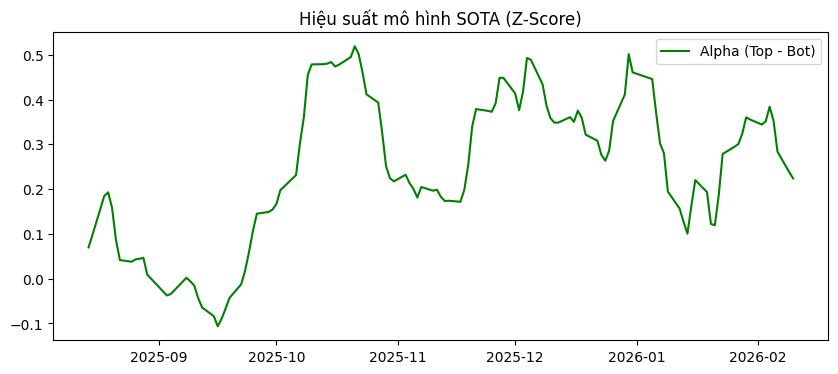

In [28]:
# Copy lại hàm evaluate_ranking_model từ câu trả lời trước, 
# nhưng nhớ gọi FeatureEngineer.process_data() mới và QuantRanker mới.
# Nhớ sửa đoạn qid = df.groupby('date').ngroup().values cho đúng.

def evaluate_new_model():
    print("📊 Evaluating SOTA Model...")
    raw_df = DataEngine.get_data(Config.TICKERS)
    
    # Process Data với Z-Score
    df = FeatureEngineer.process_data(raw_df)
    df = df.sort_values('date')
    
    # Lấy 180 ngày cuối
    cutoff = df['date'].max() - pd.Timedelta(days=180)
    test_df = df[df['date'] >= cutoff].copy()
    
    brain = QuantRanker()
    # Nếu chưa train thì train
    if not os.path.exists(brain.model_path):
        brain.train(df[df['date'] < cutoff])
    else:
        brain.load()
        
    # Predict
    test_df['Score'] = brain.predict(test_df)
    
    # Calc Spread
    res = []
    for d, g in test_df.groupby('date'):
        if len(g) < 10: continue
        top = g.nlargest(5, 'Score')['Raw_Target'].mean()
        bot = g.nsmallest(5, 'Score')['Raw_Target'].mean()
        res.append({'date': d, 'Spread': top - bot, 'Top': top, 'Bot': bot})
        
    res_df = pd.DataFrame(res)
    cum_spread = res_df['Spread'].cumsum()
    
    print(f"\n➤ CUMULATIVE SPREAD (Alpha): {res_df['Spread'].sum()*100:.2f}%")
    
    plt.figure(figsize=(10,4))
    plt.plot(res_df['date'], cum_spread, color='green', label='Alpha (Top - Bot)')
    plt.title("Hiệu suất mô hình SOTA (Z-Score)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    evaluate_new_model()